In [20]:
zip_path = "/content/archive (3).zip"
extract_path = "/content/sar_dataset"

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed!")


✅ Extraction completed!


In [22]:
import os
import json

# ✅ Corrected dataset split and annotation path
dataset_split = 'train'  # or 'train', 'valid' if needed
base_dir = f'/content/sar_dataset/SARscope/{dataset_split}'
annotation_file = os.path.join(base_dir, '_annotations.coco.json')  # confirmed path
image_dir = base_dir  # images are in the same folder

# Known corrupted image ID
faulty_image_id = 3736

# Loading annotation data
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Finding the filename of the faulty image
faulty_image = next((img for img in coco_data['images'] if img['id'] == faulty_image_id), None)

if faulty_image:
    faulty_filename = faulty_image['file_name']
    image_path = os.path.join(image_dir, faulty_filename)

    # Removing image file
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"✅ Removed image file: {faulty_filename}")
    else:
        print(f"⚠️ Image file not found: {faulty_filename}")

    # Removing image entry and related annotations from JSON
    coco_data['images'] = [img for img in coco_data['images'] if img['id'] != faulty_image_id]
    coco_data['annotations'] = [ann for ann in coco_data['annotations'] if ann['image_id'] != faulty_image_id]

    # Save updated annotations
    with open(annotation_file, 'w') as f:
        json.dump(coco_data, f)

    print("✅ Annotation file cleaned.")
else:
    print("⚠️ Image ID 3736 not found in annotations.")


✅ Removed image file: P0036_1200_2000_3600_4400_png.rf.e499cd87bc2ae09e75192dd84c702865.jpg
✅ Annotation file cleaned.


In [23]:
import os
import json
from tqdm import tqdm

# --- Adjusting paths ---
splits = ['train', 'valid', 'test']
base_path = "/content/sar_dataset/SARscope"

for split in splits:
    print(f"🛠️ Converting annotations for: {split}")

    json_path = os.path.join(base_path, split, "_annotations.coco.json")
    image_dir = os.path.join(base_path, split)
    labels_dir = os.path.join(base_path, split, "labels")

    # label folder
    os.makedirs(labels_dir, exist_ok=True)

    with open(json_path) as f:
        data = json.load(f)

    # lookup tables
    images = {img['id']: img['file_name'] for img in data['images']}
    annotations = {}
    for ann in data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations:
            annotations[image_id] = []
        annotations[image_id].append(ann)

    # Converting each image's annotations to YOLO format
    for image_id, file_name in tqdm(images.items()):
        width = height = 640  # Your dataset uses resized 640x640 images
        label_path = os.path.join(labels_dir, file_name.replace('.jpg', '.txt'))

        with open(label_path, "w") as f:
            for ann in annotations.get(image_id, []):
                x, y, w, h = ann['bbox']
                xc = (x + w / 2) / width
                yc = (y + h / 2) / height
                w /= width
                h /= height
                class_id = ann['category_id'] - 1  # YOLO requires class_id starting from 0
                f.write(f"{class_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

    print(f"✅ Finished converting {split}.")


🛠️ Converting annotations for: train


100%|██████████| 4716/4716 [00:00<00:00, 16983.80it/s]


✅ Finished converting train.
🛠️ Converting annotations for: valid


100%|██████████| 1346/1346 [00:00<00:00, 16866.23it/s]


✅ Finished converting valid.
🛠️ Converting annotations for: test


100%|██████████| 672/672 [00:00<00:00, 17223.49it/s]

✅ Finished converting test.


In [24]:
# Clone the YOLOv5 repo
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17360, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 17360 (delta 36), reused 18 (delta 18), pack-reused 17308 (from 2)
Receiving objects: 100% (17360/17360), 16.25 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (11901/11901), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s e

In [25]:
dataset_yaml = """
train: /content/sar_dataset/SARscope/train/images
val: /content/sar_dataset/SARscope/valid/images

nc: 1
names: ['ship']
"""

with open("/content/yolov5/data/sarscope.yaml", "w") as f:
    f.write(dataset_yaml)

print("✅ YOLO dataset config written to yolov5/data/sarscope.yaml")


✅ YOLO dataset config written to yolov5/data/sarscope.yaml


In [26]:
import os
import shutil

# valid directory
valid_dir = '/content/sar_dataset/SARscope/valid'
images_dir = os.path.join(valid_dir, 'images')

# images directory
os.makedirs(images_dir, exist_ok=True)

# Moving all .jpg files from valid/ to valid/images/
for file in os.listdir(valid_dir):
    if file.endswith('.jpg'):
        src = os.path.join(valid_dir, file)
        dst = os.path.join(images_dir, file)
        shutil.move(src, dst)

print("✅ Moved validation images into valid/images/")


✅ Moved validation images into valid/images/


In [27]:
import os
import shutil

train_dir = '/content/sar_dataset/SARscope/train'
images_dir = os.path.join(train_dir, 'images')

os.makedirs(images_dir, exist_ok=True)

# Moving all .jpg files from train/ to train/images/
for file in os.listdir(train_dir):
    if file.endswith('.jpg'):
        src = os.path.join(train_dir, file)
        dst = os.path.join(images_dir, file)
        shutil.move(src, dst)

print("✅ Moved training images into train/images/")


✅ Moved training images into train/images/


# Starting Model training on training data

In [28]:
!python /content/yolov5/train.py \
  --img 640 \
  --batch 16 \
  --epochs 5 \
  --data /content/yolov5/data/sarscope.yaml \
  --weights yolov5s.pt \
  --name yolov5_sarscope6



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-01 17:01:33.330034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743526893.626438    6886 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743526893.702800    6886 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

# Results Visualization

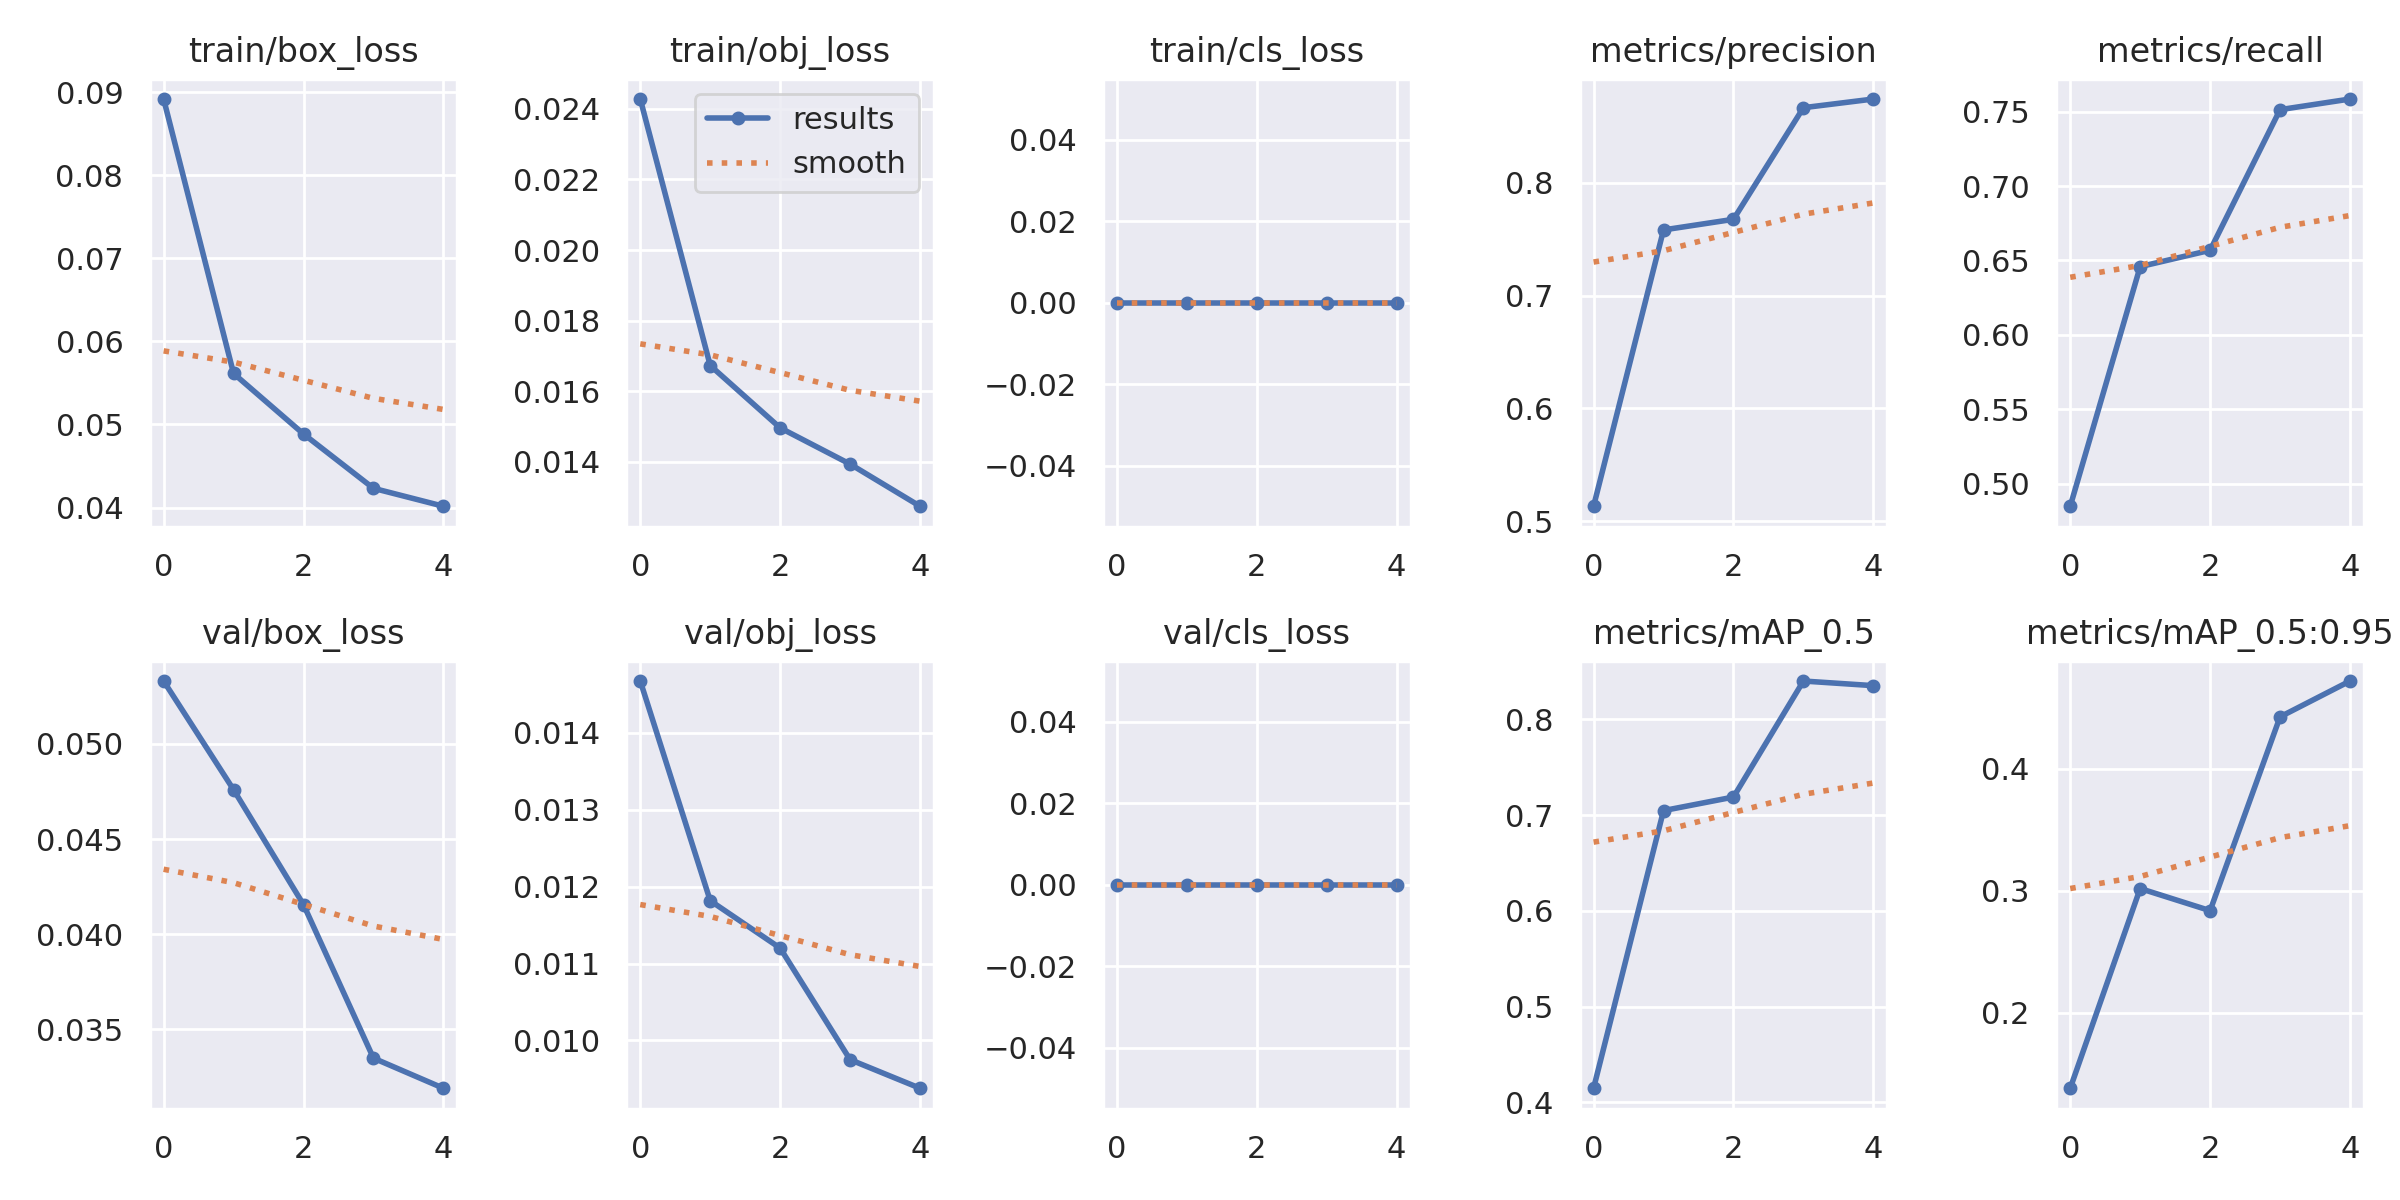

In [45]:
# training results visualization
from IPython.display import Image, display
display(Image(filename='/content/yolov5/runs/train/yolov5_sarscope6/results.png', width=800))


In [46]:
# training results nubers
import pandas as pd
metrics = pd.read_csv('/content/yolov5/runs/train/yolov5_sarscope6/results.csv')
metrics.head()



,epoch,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95,val/box_loss,val/obj_loss,val/cls_loss,x/lr0,x/lr1,x/lr2
0,0,0.089158,0.024279,0,0.51337,0.48479,0.41480,0.13804,0.053308,0.014676,0,0.070102,0.003322,0.003322
1,1,0.056130,0.016730,0,0.75819,0.64586,0.70473,0.30183,0.047592,0.011818,0,0.038784,0.005338,0.005338
2,2,0.048849,0.014964,0,0.76758,0.65685,0.71890,0.28371,0.041549,0.011201,0,0.006146,0.006033,0.006033
3,3,0.042310,0.013938,0,0.86647,0.75139,0.84005,0.44265,0.033476,0.009750,0,0.004060,0.004060,0.004060
4,4,0.040153,0.012744,0,0.87415,0.75853,0.83522,0.47204,0.031893,0.009378,0,0.004060,0.004060,0.004060


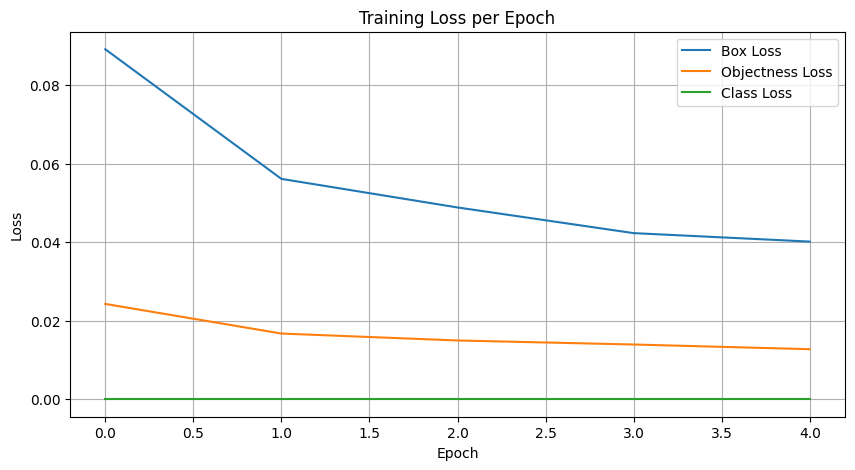

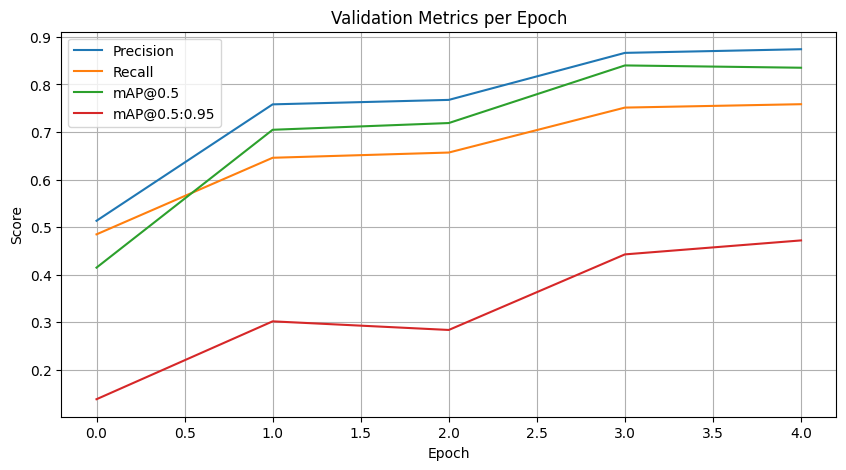

In [47]:
# training results visualization
import pandas as pd
import matplotlib.pyplot as plt

# results CSV
df = pd.read_csv("/content/yolov5/runs/train/yolov5_sarscope6/results.csv")


df.columns = df.columns.str.strip()

# Training Losses
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/obj_loss'], label='Objectness Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Validation Metrics
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/precision'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.title("Validation Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


# Testing Model on Test Data

In [49]:
# model weights
weights_path = '/content/yolov5/runs/train/yolov5_sarscope6/weights/best.pt'

# test images
test_images_path = '/content/sar_dataset/SARscope/test'


In [50]:
!python /content/yolov5/detect.py \
  --weights {'/content/yolov5/runs/train/yolov5_sarscope6/weights/best.pt'} \
  --img 640 \
  --conf 0.25 \
  --source {'/content/sar_dataset/SARscope/test'} \
  --project runs/test \
  --name yolov5_sarscope6_predictions \
  --exist-ok


detect: weights=['/content/yolov5/runs/train/yolov5_sarscope6/weights/best.pt'], source=/content/sar_dataset/SARscope/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/test, name=yolov5_sarscope6_predictions, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/672 /content/sar_dataset/SARscope/test/000003_jpg.rf.d35f1b3e7a2f971d5edb6bd95bdb0af4.jpg: 640x640 1 ship, 11.4ms
image 2/672 /content/sar_dataset/SARscope/test/000047_jpg.rf.a7c5a75819459815e026bd5f7c0c5d3d.jpg: 640x640 2 ships, 11.5ms
ima

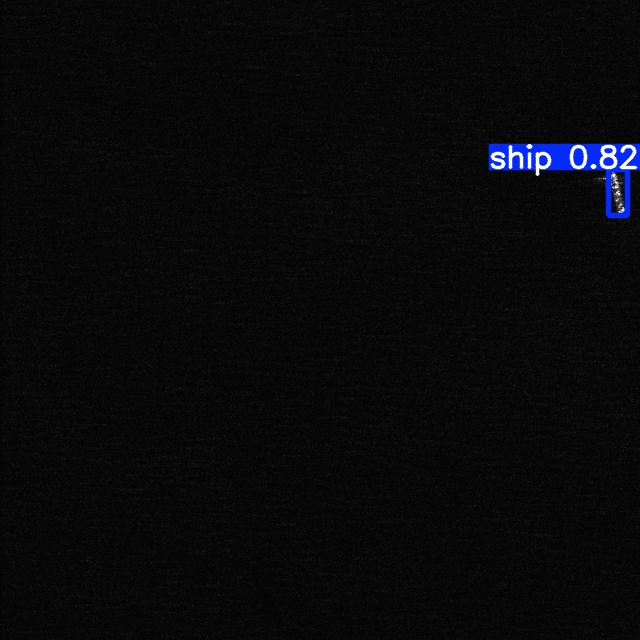

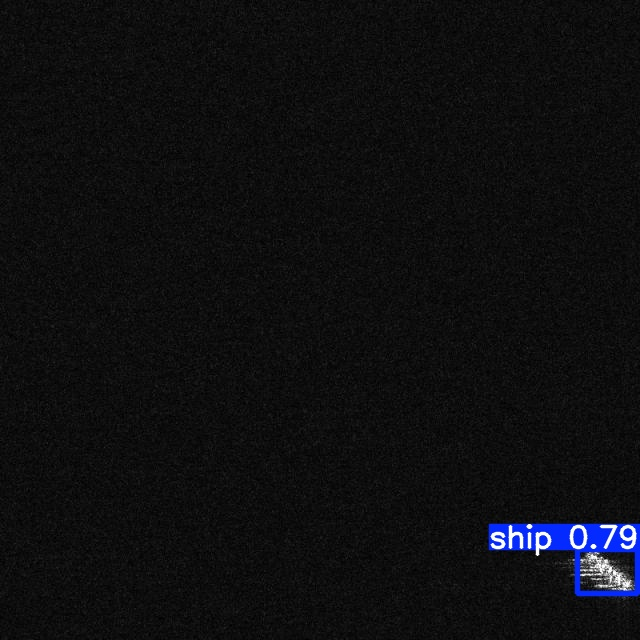

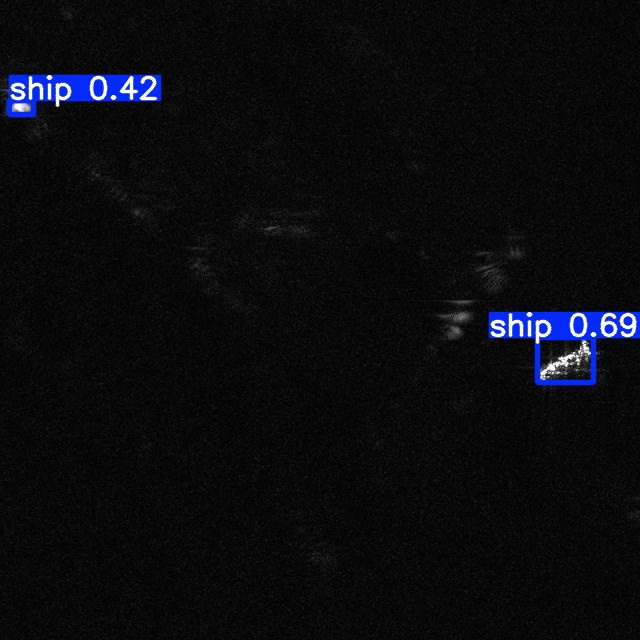

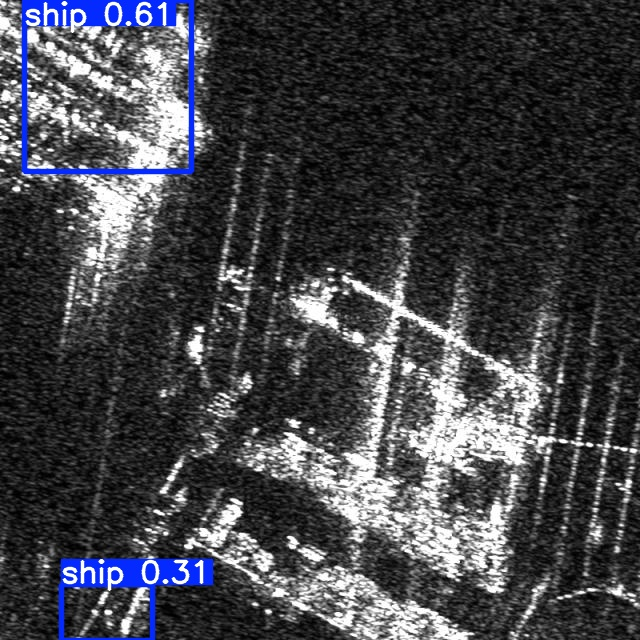

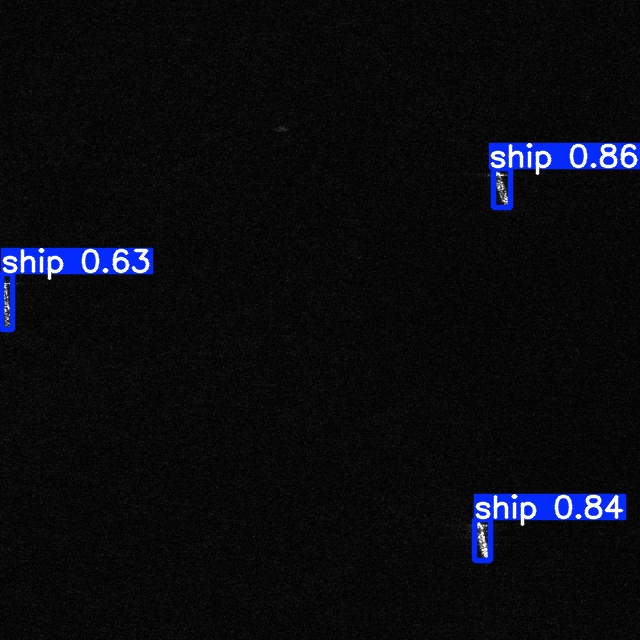

In [54]:
from IPython.display import Image, display
import os

# prediction outputs
pred_dir = '/content/yolov5/runs/test/yolov5_sarscope6_predictions'

# first few results
for file_name in os.listdir(pred_dir)[:5]:  # adjust number as needed
    if file_name.endswith('.jpg'):
        display(Image(filename=os.path.join(pred_dir, file_name), width=200))


# YOLOv5 Architecture Experimentation: Adding Convolution Blocks to YOLOv5


In [74]:
cp /content/yolov5/models/yolov5s.yaml /content/yolov5/models/yolov5s_convexp.yaml

In [75]:
!python /content/yolov5/train.py \
  --img 640 \
  --batch 16 \
  --epochs 5 \
  --data /content/yolov5/data/sarscope.yaml \
  --cfg /content/yolov5/models/yolov5s_convexp.yaml \
  --weights yolov5s.pt \
  --name yolov5_sarscope_exp




wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-01 19:13:06.284925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743534786.307951   40441 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743534786.314908   40441 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&

# Performance Comparison: Original YOLOv5 vs Modified YOLOv5 with Extra Convolution Layers

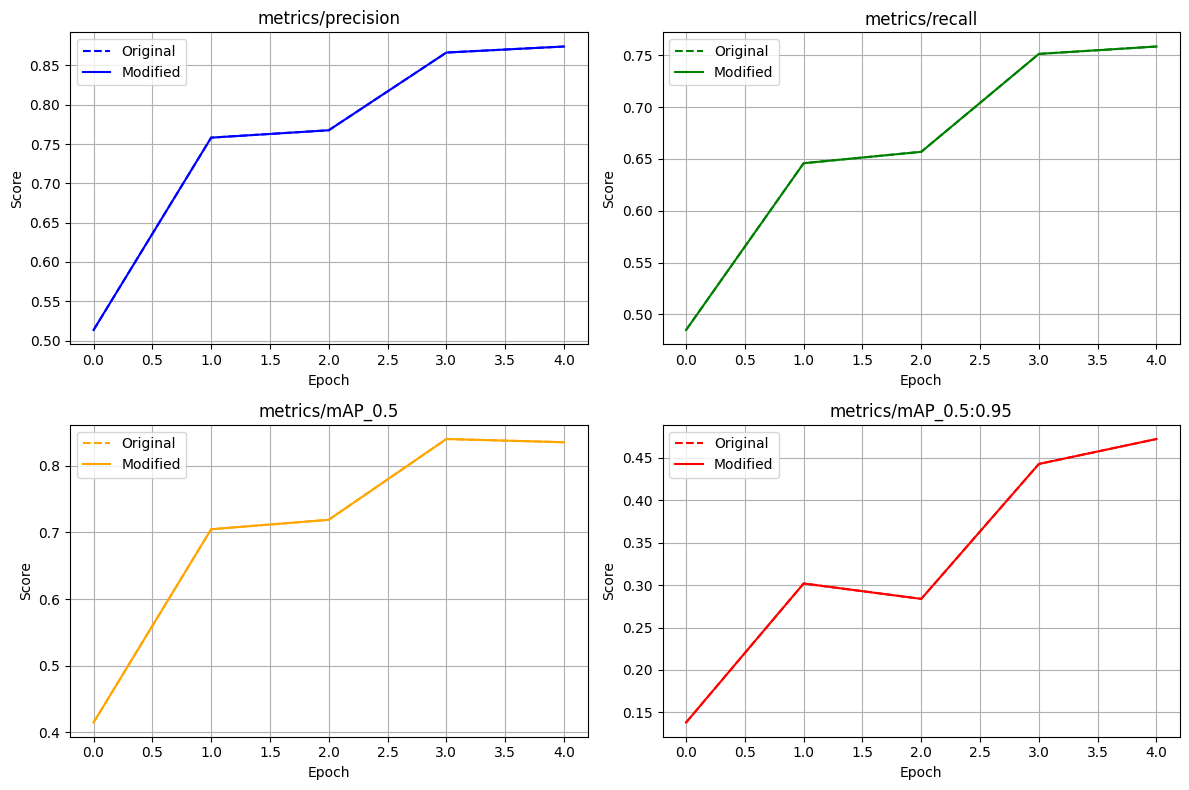

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to results.csv for both models
original_results = '/content/yolov5/runs/train/yolov5_sarscope6/results.csv'
modified_results = '/content/yolov5/runs/train/yolov5_sarscope_exp2/results.csv'

# Load CSVs
df_orig = pd.read_csv(original_results)
df_mod = pd.read_csv(modified_results)

# Strip column names
df_orig.columns = df_orig.columns.str.strip()
df_mod.columns = df_mod.columns.str.strip()

# Plot comparison
metrics = ['metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(df_orig['epoch'], df_orig[metric], label='Original', linestyle='--', color=colors[i])
    plt.plot(df_mod['epoch'], df_mod[metric], label='Modified', linestyle='-', color=colors[i])
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


<ipython-input-83-5aacafb81c0d>:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


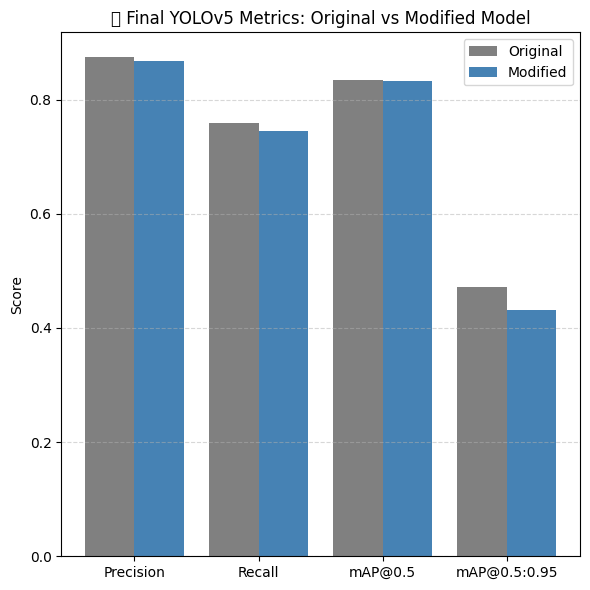

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# both metrics files
orig_metrics = pd.read_csv('/content/yolov5/runs/train/yolov5_sarscope6/results.csv')
mod_metrics = pd.read_csv('/content/yolov5/runs/train/yolov5_sarscope_exp/results.csv')

# column names
orig_metrics.columns = orig_metrics.columns.str.strip()
mod_metrics.columns = mod_metrics.columns.str.strip()

# metrics to compare
metrics_to_plot = ['metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']
metric_labels = ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95']

# Extracting last epoch values
orig_last = orig_metrics.iloc[-1]
mod_last = mod_metrics.iloc[-1]

# Creating bar plot
x = range(len(metrics_to_plot))
plt.figure(figsize=(6, 6))

plt.bar([i - 0.2 for i in x], [orig_last[m] for m in metrics_to_plot], width=0.4, label='Original', color='gray')
plt.bar([i + 0.2 for i in x], [mod_last[m] for m in metrics_to_plot], width=0.4, label='Modified', color='steelblue')

plt.xticks(ticks=x, labels=metric_labels)
plt.ylabel("Score")
plt.title("📊 Final YOLOv5 Metrics: Original vs Modified Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
